# 03 — Classification Modelling
Mục tiêu: train mô hình phân lớp AQI (6 lớp), split theo thời gian, đánh giá bằng accuracy + macro-F1, confusion matrix, và lưu metrics/prediction sample.

In [1]:
DATASET_PATH = 'data/processed/dataset_for_clf.parquet'
CUTOFF = '2017-01-01'
METRICS_PATH = 'data/processed/metrics.json'
PRED_SAMPLE_PATH = 'data/processed/predictions_sample.csv'


In [2]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.classification_library import time_split, train_classifier, AQI_CLASSES

# ===== Auto detect PROJECT_ROOT (compatible with papermill) =====
HERE = Path.cwd()
PROJECT_ROOT = HERE
while not (PROJECT_ROOT / "data").exists() and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

print("PROJECT_ROOT =", PROJECT_ROOT)

dataset_path = (PROJECT_ROOT / DATASET_PATH).resolve()
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()

metrics_path.parent.mkdir(parents=True, exist_ok=True)
pred_path.parent.mkdir(parents=True, exist_ok=True)

print("Dataset path:", dataset_path)


PROJECT_ROOT = D:\KPDL\miniproject2
Dataset path: D:\KPDL\miniproject2\data\processed\dataset_for_clf.parquet


In [3]:
df = pd.read_parquet(dataset_path)
print('shape:', df.shape)
df[['datetime','station','aqi_class']].head()

shape: (347740, 55)


,datetime,station,aqi_class
0,2013-03-02 00:00:00,Aotizhongxin,Good
1,2013-03-02 01:00:00,Aotizhongxin,Good
2,2013-03-02 02:00:00,Aotizhongxin,Good
3,2013-03-02 03:00:00,Aotizhongxin,Good
4,2013-03-02 04:00:00,Aotizhongxin,Good


In [4]:
train_df, test_df = time_split(df, cutoff=CUTOFF)
print('train:', train_df.shape, '| test:', test_df.shape)
print('test date range:', test_df['datetime'].min(), '->', test_df['datetime'].max())

train: (333061, 55) | test: (14679, 55)
test date range: 2017-01-01 00:00:00 -> 2017-02-28 23:00:00


In [5]:
out = train_classifier(train_df, test_df, target_col='aqi_class')
metrics = out['metrics']
pred_df = out['pred_df']

print('Accuracy:', metrics['accuracy'])
print('F1-macro:', metrics['f1_macro'])
pred_df.head()

Accuracy: 0.6081476939846039
F1-macro: 0.47781044278021184


,datetime,station,y_true,y_pred
0,2017-01-01 00:00:00,Aotizhongxin,Hazardous,Hazardous
1,2017-01-01 01:00:00,Aotizhongxin,Hazardous,Hazardous
2,2017-01-01 02:00:00,Aotizhongxin,Hazardous,Hazardous
3,2017-01-01 03:00:00,Aotizhongxin,Hazardous,Hazardous
4,2017-01-01 04:00:00,Aotizhongxin,Hazardous,Hazardous


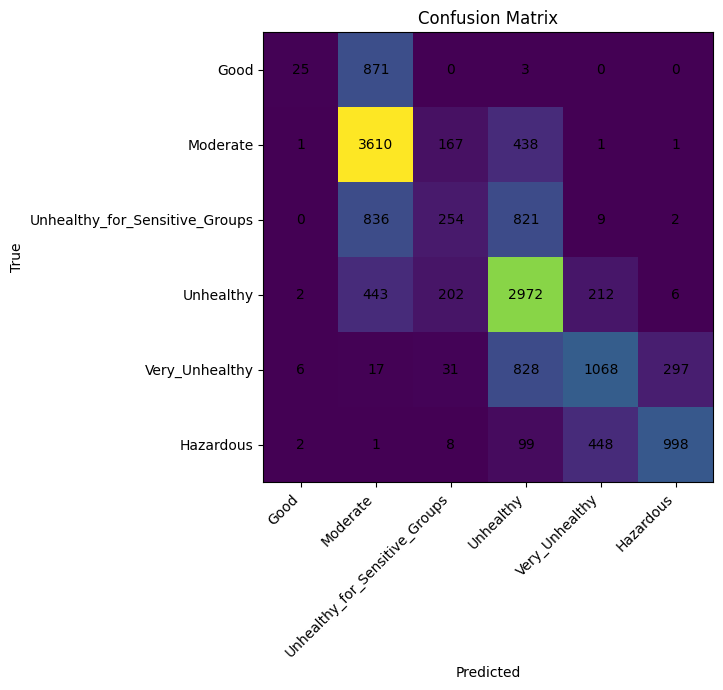

In [6]:
# Confusion matrix plot
cm = np.array(metrics['confusion_matrix'])
labels = metrics['labels']

plt.figure(figsize=(9, 7))
plt.imshow(cm)
plt.title('Confusion Matrix')
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(int(cm[i, j])), ha='center', va='center')

plt.tight_layout()
plt.show()

In [7]:
# Lưu metrics + sample prediction
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

pred_df.head(5000).to_csv(pred_path, index=False)
print('Saved:', metrics_path)
print('Saved:', pred_path)

Saved: D:\KPDL\miniproject2\data\processed\metrics.json
Saved: D:\KPDL\miniproject2\data\processed\predictions_sample.csv


In [8]:
# In classification report (rút gọn)
report = metrics['report']
summary = {k: report[k] for k in ['accuracy', 'macro avg', 'weighted avg'] if k in report}
summary

{'accuracy': 0.6081476939846039,
 'macro avg': {'precision': 0.6097680245221171,
  'recall': 0.4845117624641453,
  'f1-score': 0.47781044278021184,
  'support': 14679.0},
 'weighted avg': {'precision': 0.5980173855280898,
  'recall': 0.6081476939846039,
  'f1-score': 0.5652689432327836,
  'support': 14679.0}}

Class distribution (ALL):
aqi_class
Good                               11593
Hazardous                          16685
Moderate                           92815
Unhealthy                         125020
Unhealthy_for_Sensitive_Groups     54259
Very_Unhealthy                     47368
Name: count, dtype: int64

Class distribution (TEST):
aqi_class
Good                               899
Hazardous                         1556
Moderate                          4218
Unhealthy                         3837
Unhealthy_for_Sensitive_Groups    1922
Very_Unhealthy                    2247
Name: count, dtype: int64


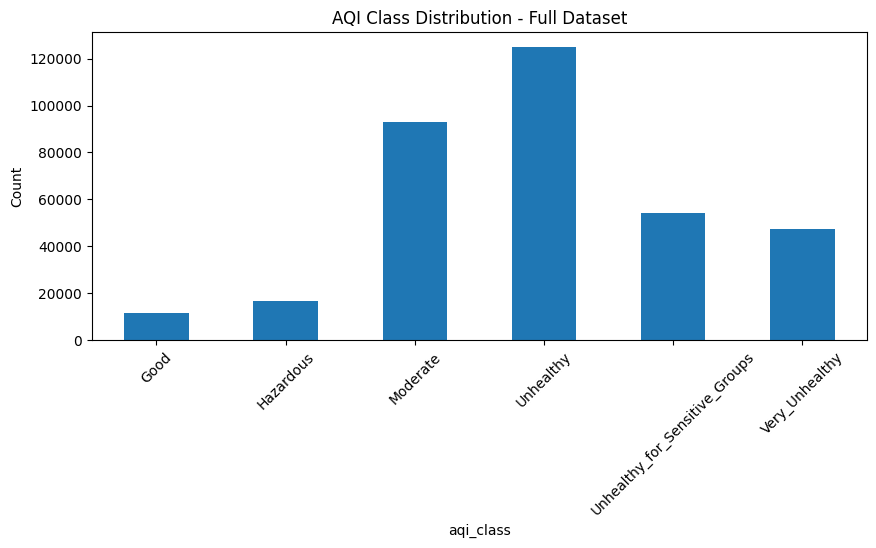

In [9]:
# ===== Class distribution =====
import matplotlib.pyplot as plt

dist_all = df['aqi_class'].value_counts().sort_index()
dist_test = test_df['aqi_class'].value_counts().sort_index()

print("Class distribution (ALL):")
print(dist_all)

print("\nClass distribution (TEST):")
print(dist_test)

plt.figure(figsize=(10,4))
dist_all.plot(kind='bar')
plt.title("AQI Class Distribution - Full Dataset")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [10]:
# ===== Feature Importance =====

model = out.get("model", None)

if model is not None and hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    feature_names = [c for c in train_df.columns if c not in ['aqi_class']]

    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    print("Top 15 important features:")
    print(fi.head(15))

    plt.figure(figsize=(8,5))
    fi.head(15).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title("Top 15 Feature Importances (Baseline Model)")
    plt.xlabel("Importance")
    plt.show()
else:
    print("Model does not support feature importance.")


Model does not support feature importance.


In [11]:
# ===== Compare with Semi-supervised (robust) =====
import json

self_path = PROJECT_ROOT / "data/processed/metrics_self_training.json"
co_path = PROJECT_ROOT / "data/processed/metrics_co_training.json"

rows = []

# Baseline
rows.append({
    "Model": "Supervised baseline",
    "Accuracy": metrics.get("accuracy"),
    "F1-macro": metrics.get("f1_macro")
})

def extract_scores(m):
    # try multiple possible structures
    if "accuracy" in m:
        return m.get("accuracy"), m.get("f1_macro")
    if "metrics" in m:
        return m["metrics"].get("accuracy"), m["metrics"].get("f1_macro")
    if "report" in m and "accuracy" in m["report"]:
        return m["report"]["accuracy"], None
    return None, None

# Self-training
if self_path.exists():
    with open(self_path) as f:
        m = json.load(f)
    acc, f1 = extract_scores(m)
    rows.append({
        "Model": "Self-training",
        "Accuracy": acc,
        "F1-macro": f1
    })

# Co-training
if co_path.exists():
    with open(co_path) as f:
        m = json.load(f)
    acc, f1 = extract_scores(m)
    rows.append({
        "Model": "Co-training",
        "Accuracy": acc,
        "F1-macro": f1
    })

compare_df = pd.DataFrame(rows)
compare_df


,Model,Accuracy,F1-macro
0,Supervised baseline,0.608148,0.47781
1,Self-training,NaN,NaN
2,Co-training,NaN,NaN
